[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sunyeul/playground/blob/main/Data-Shapley/knn_data_shapley.ipynb)

## Import Libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from scipy.stats import zscore
from tqdm import tqdm

pd.options.display.precision = 6

## Define Functions

In [4]:
def compute_unweighted_knn_class_shapley(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    K: int) -> np.ndarray:

    dist_matrix = pairwise_distances(X=X_test, Y=X_train, metric='euclidean', n_jobs=-1)
    dist_idx_matrix = np.argsort(dist_matrix, axis=1)

    N_train = X_train.shape[0]
    N_valid = X_test.shape[0]
    sp_gt = np.zeros((N_valid, N_train))

    for j in tqdm(range(N_valid)):
        a_N = dist_idx_matrix[j, -1]
        sp_gt[j, a_N] = (y_train[a_N] == y_test[j]) / N_train

        for i in np.arange(N_train - 2, -1, -1):
            a_i = dist_idx_matrix[j, i]
            a_ip1 = dist_idx_matrix[j, i + 1]
            sp_gt[j, a_i] = sp_gt[j, a_ip1]
            sp_gt[j, a_i] += (int(y_train[a_i] == y_test[j]) - int(y_train[a_ip1] == y_test[j])) / K * min([K, i + 1]) / (i + 1)

    return dist_matrix, sp_gt

## Load Data

/Users/junhyeong.kim/Workspaces/playground/.venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


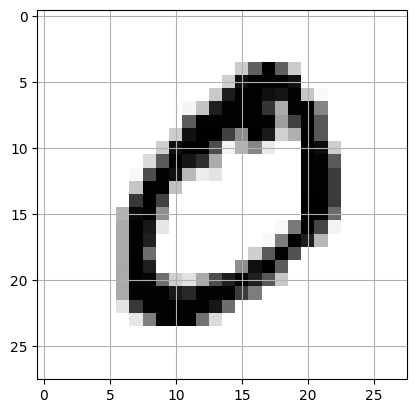

In [5]:
X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

plt.imshow(X[1].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
plt.grid(True)
plt.show()

## Split Data & Train Model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5_000, test_size=1_000, shuffle=True, stratify=y, random_state=3407)

X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(5000, 784) (1000, 784)


In [7]:
clf = RandomForestClassifier(random_state=3655)

clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

print(clf.score(X_test, y_test))

0.945


## Investigate misclassified test data

probability: {'0': '6.0%', '1': '0.0%', '2': '3.0%', '3': '2.0%', '4': '37.0%', '5': '5.0%', '6': '2.0%', '7': '18.0%', '8': '3.0%', '9': '24.0%'}


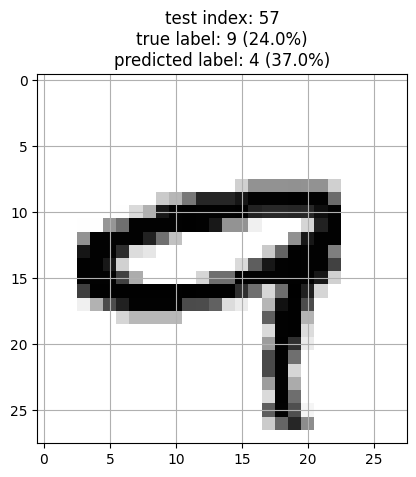

In [10]:
misclf_idxs = np.argwhere(y_pred != y_test).flatten()

misclf_idx = misclf_idxs[0]

true_label = y_test[misclf_idx]
pred_label = y_pred[misclf_idx]
pred_proba = {str(i): f'{p*100:.1f}%' for i, p in enumerate(y_pred_proba[misclf_idx])}

print('probability:', pred_proba)
plt.title(f'test index: {misclf_idx}\ntrue label: {true_label} ({pred_proba[true_label]})\npredicted label: {pred_label} ({pred_proba[pred_label]})')
plt.imshow(X_test[misclf_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")

plt.grid(True)
plt.show()

## Calculate data-shapley values

In [11]:
dist_matrix, sv_matrix = compute_unweighted_knn_class_shapley(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_pred,
    K=20
)

100%|██████████| 1000/1000 [00:21<00:00, 46.25it/s]


## Investigate train data constributing misclassifited test data in good or bad way

### The most contributing train data

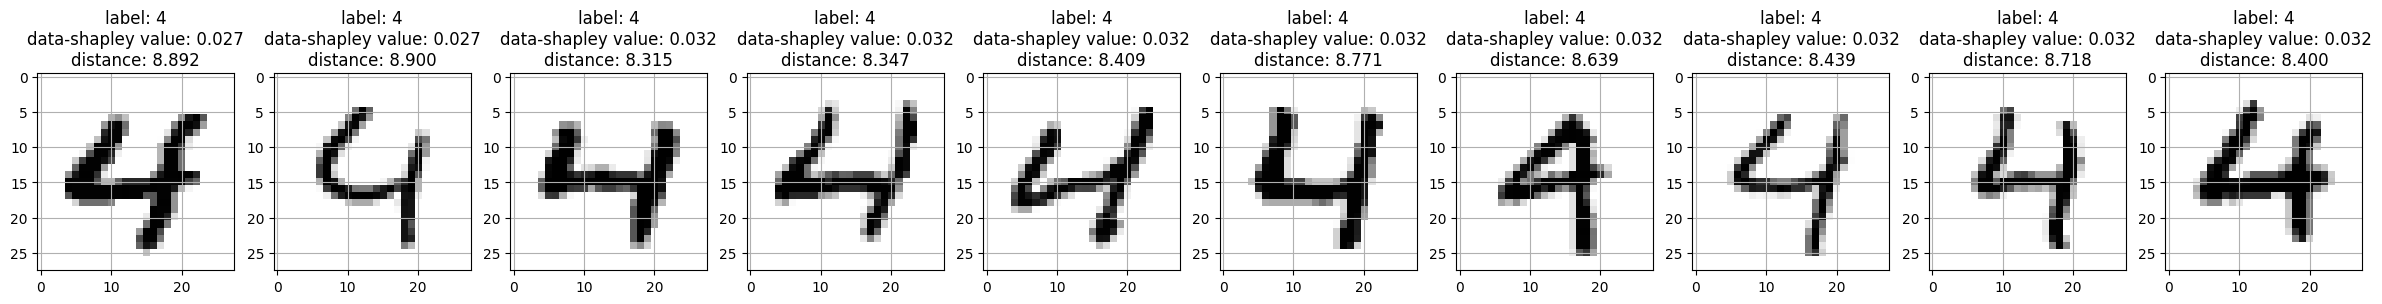

In [12]:
k = 10

top_k = np.argsort(sv_matrix[misclf_idx])[-k:]

fig, axes = plt.subplots(1, k, figsize=(k*3, 12))

for ax, train_idx in zip(axes, top_k):
    sv = sv_matrix[misclf_idx, train_idx]
    dist = dist_matrix[misclf_idx, train_idx]
    ax.set_title(f'label: {y_train[train_idx]}\ndata-shapley value: {sv:.3f}\ndistance: {dist:.3f}')
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.grid(True)
plt.show()

### The least contributing train data

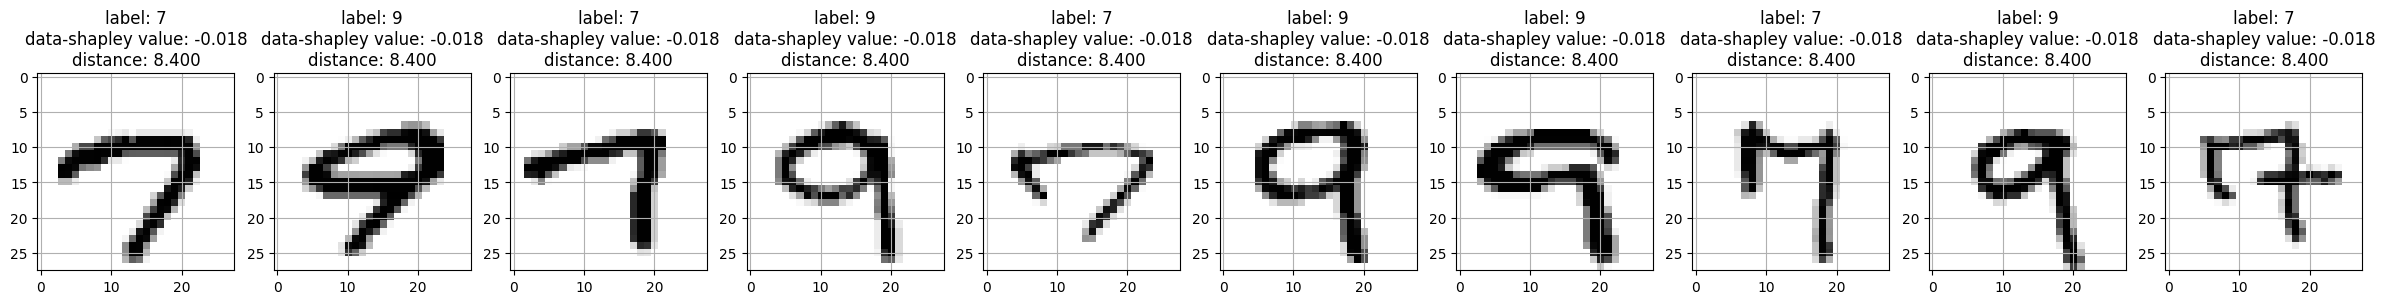

In [13]:
k = 10

bottom_k = np.argsort(sv_matrix[misclf_idx])[:k]

fig, axes = plt.subplots(1, k, figsize=(k*3, 12))

for ax, train_idx in zip(axes, bottom_k):
    sv = sv_matrix[misclf_idx, train_idx]
    ax.set_title(f'label: {y_train[train_idx]}\ndata-shapley value: {sv:.3f}\ndistance: {dist:.3f}')
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.grid(True)
plt.show()

probability: {'0': '6.0%', '1': '0.0%', '2': '3.0%', '3': '2.0%', '4': '37.0%', '5': '5.0%', '6': '2.0%', '7': '18.0%', '8': '3.0%', '9': '24.0%'}


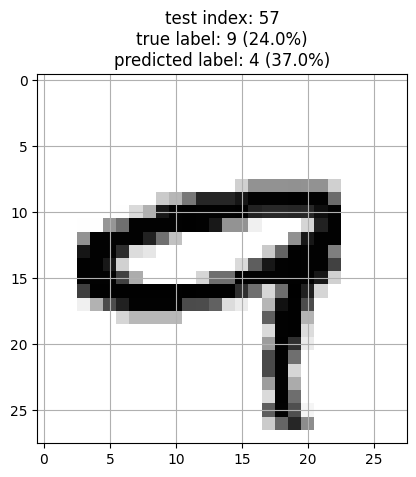

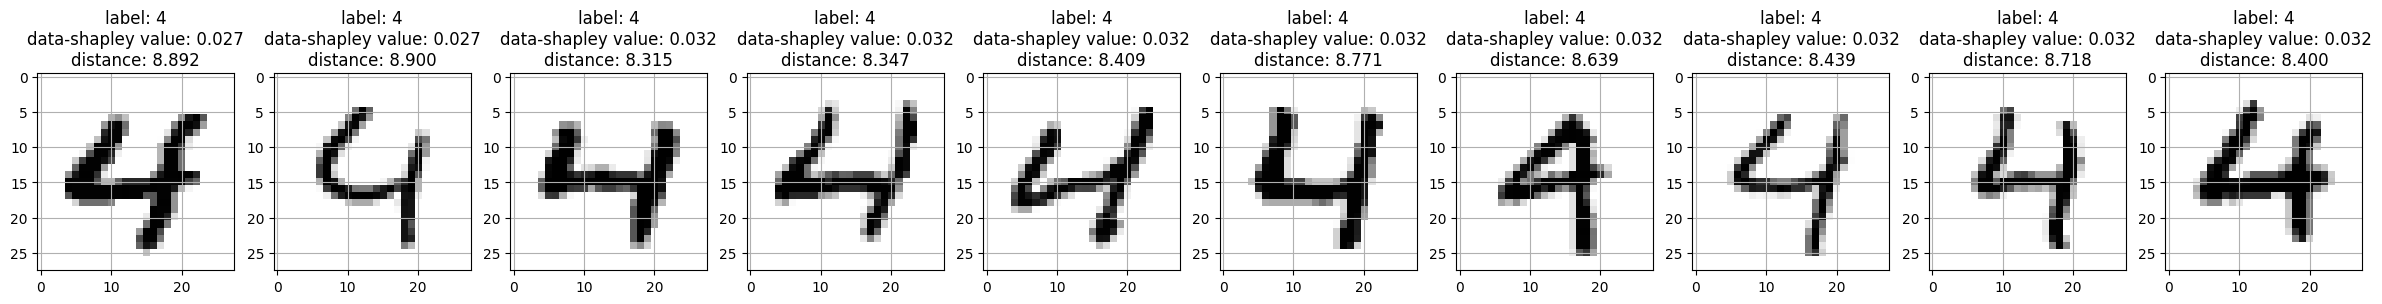

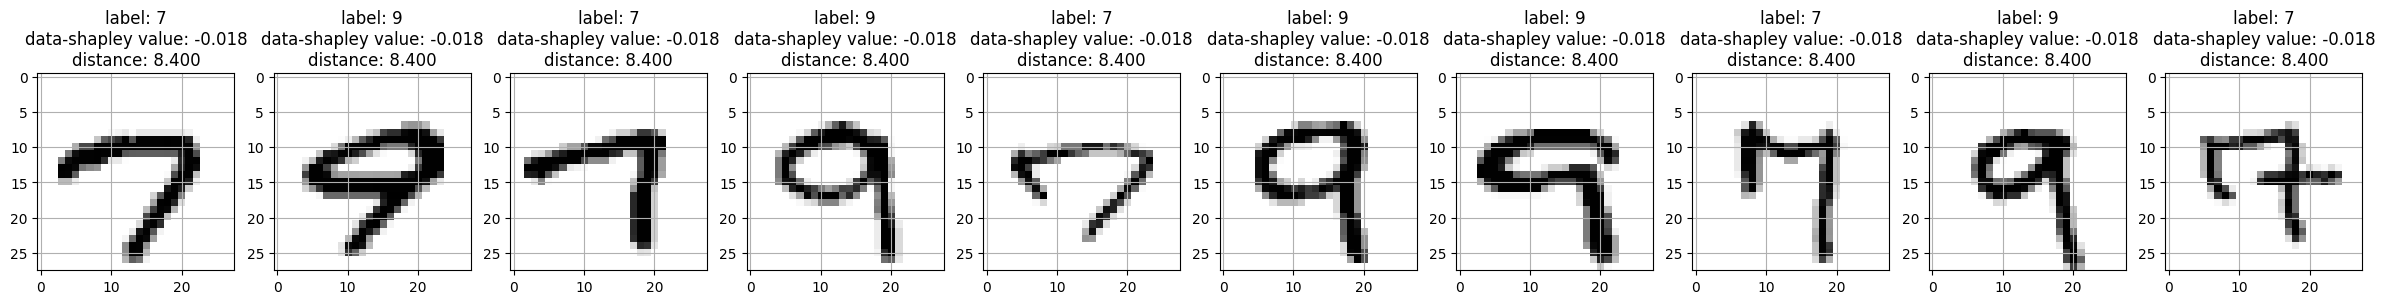

In [14]:
misclf_idx = misclf_idxs[0]

true_label = y_test[misclf_idx]
pred_label = y_pred[misclf_idx]
pred_proba = {str(i): f'{p*100:.1f}%' for i, p in enumerate(y_pred_proba[misclf_idx])}

print('probability:', pred_proba)
plt.title(f'test index: {misclf_idx}\ntrue label: {true_label} ({pred_proba[true_label]})\npredicted label: {pred_label} ({pred_proba[pred_label]})')
plt.imshow(X_test[misclf_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")

plt.grid(True)
plt.show()

k = 10

top_k = np.argsort(sv_matrix[misclf_idx])[-k:]

fig, axes = plt.subplots(1, k, figsize=(k*3, 12))

for ax, train_idx in zip(axes, top_k):
    sv = sv_matrix[misclf_idx, train_idx]
    dist = dist_matrix[misclf_idx, train_idx]
    ax.set_title(f'label: {y_train[train_idx]}\ndata-shapley value: {sv:.3f}\ndistance: {dist:.3f}')
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.grid(True)
plt.show()


bottom_k = np.argsort(sv_matrix[misclf_idx])[:k]

fig, axes = plt.subplots(1, k, figsize=(k*3, 12))

for ax, train_idx in zip(axes, bottom_k):
    sv = sv_matrix[misclf_idx, train_idx]
    ax.set_title(f'label: {y_train[train_idx]}\ndata-shapley value: {sv:.3f}\ndistance: {dist:.3f}')
    ax.imshow(X_train[train_idx].reshape(28, -1), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.grid(True)
plt.show()

## Visualization

In [15]:
tsne = TSNE()

tsne_df = pd.DataFrame(
    data=tsne.fit_transform(np.vstack([X_train, X_test])),
    columns=['x', 'y']
)

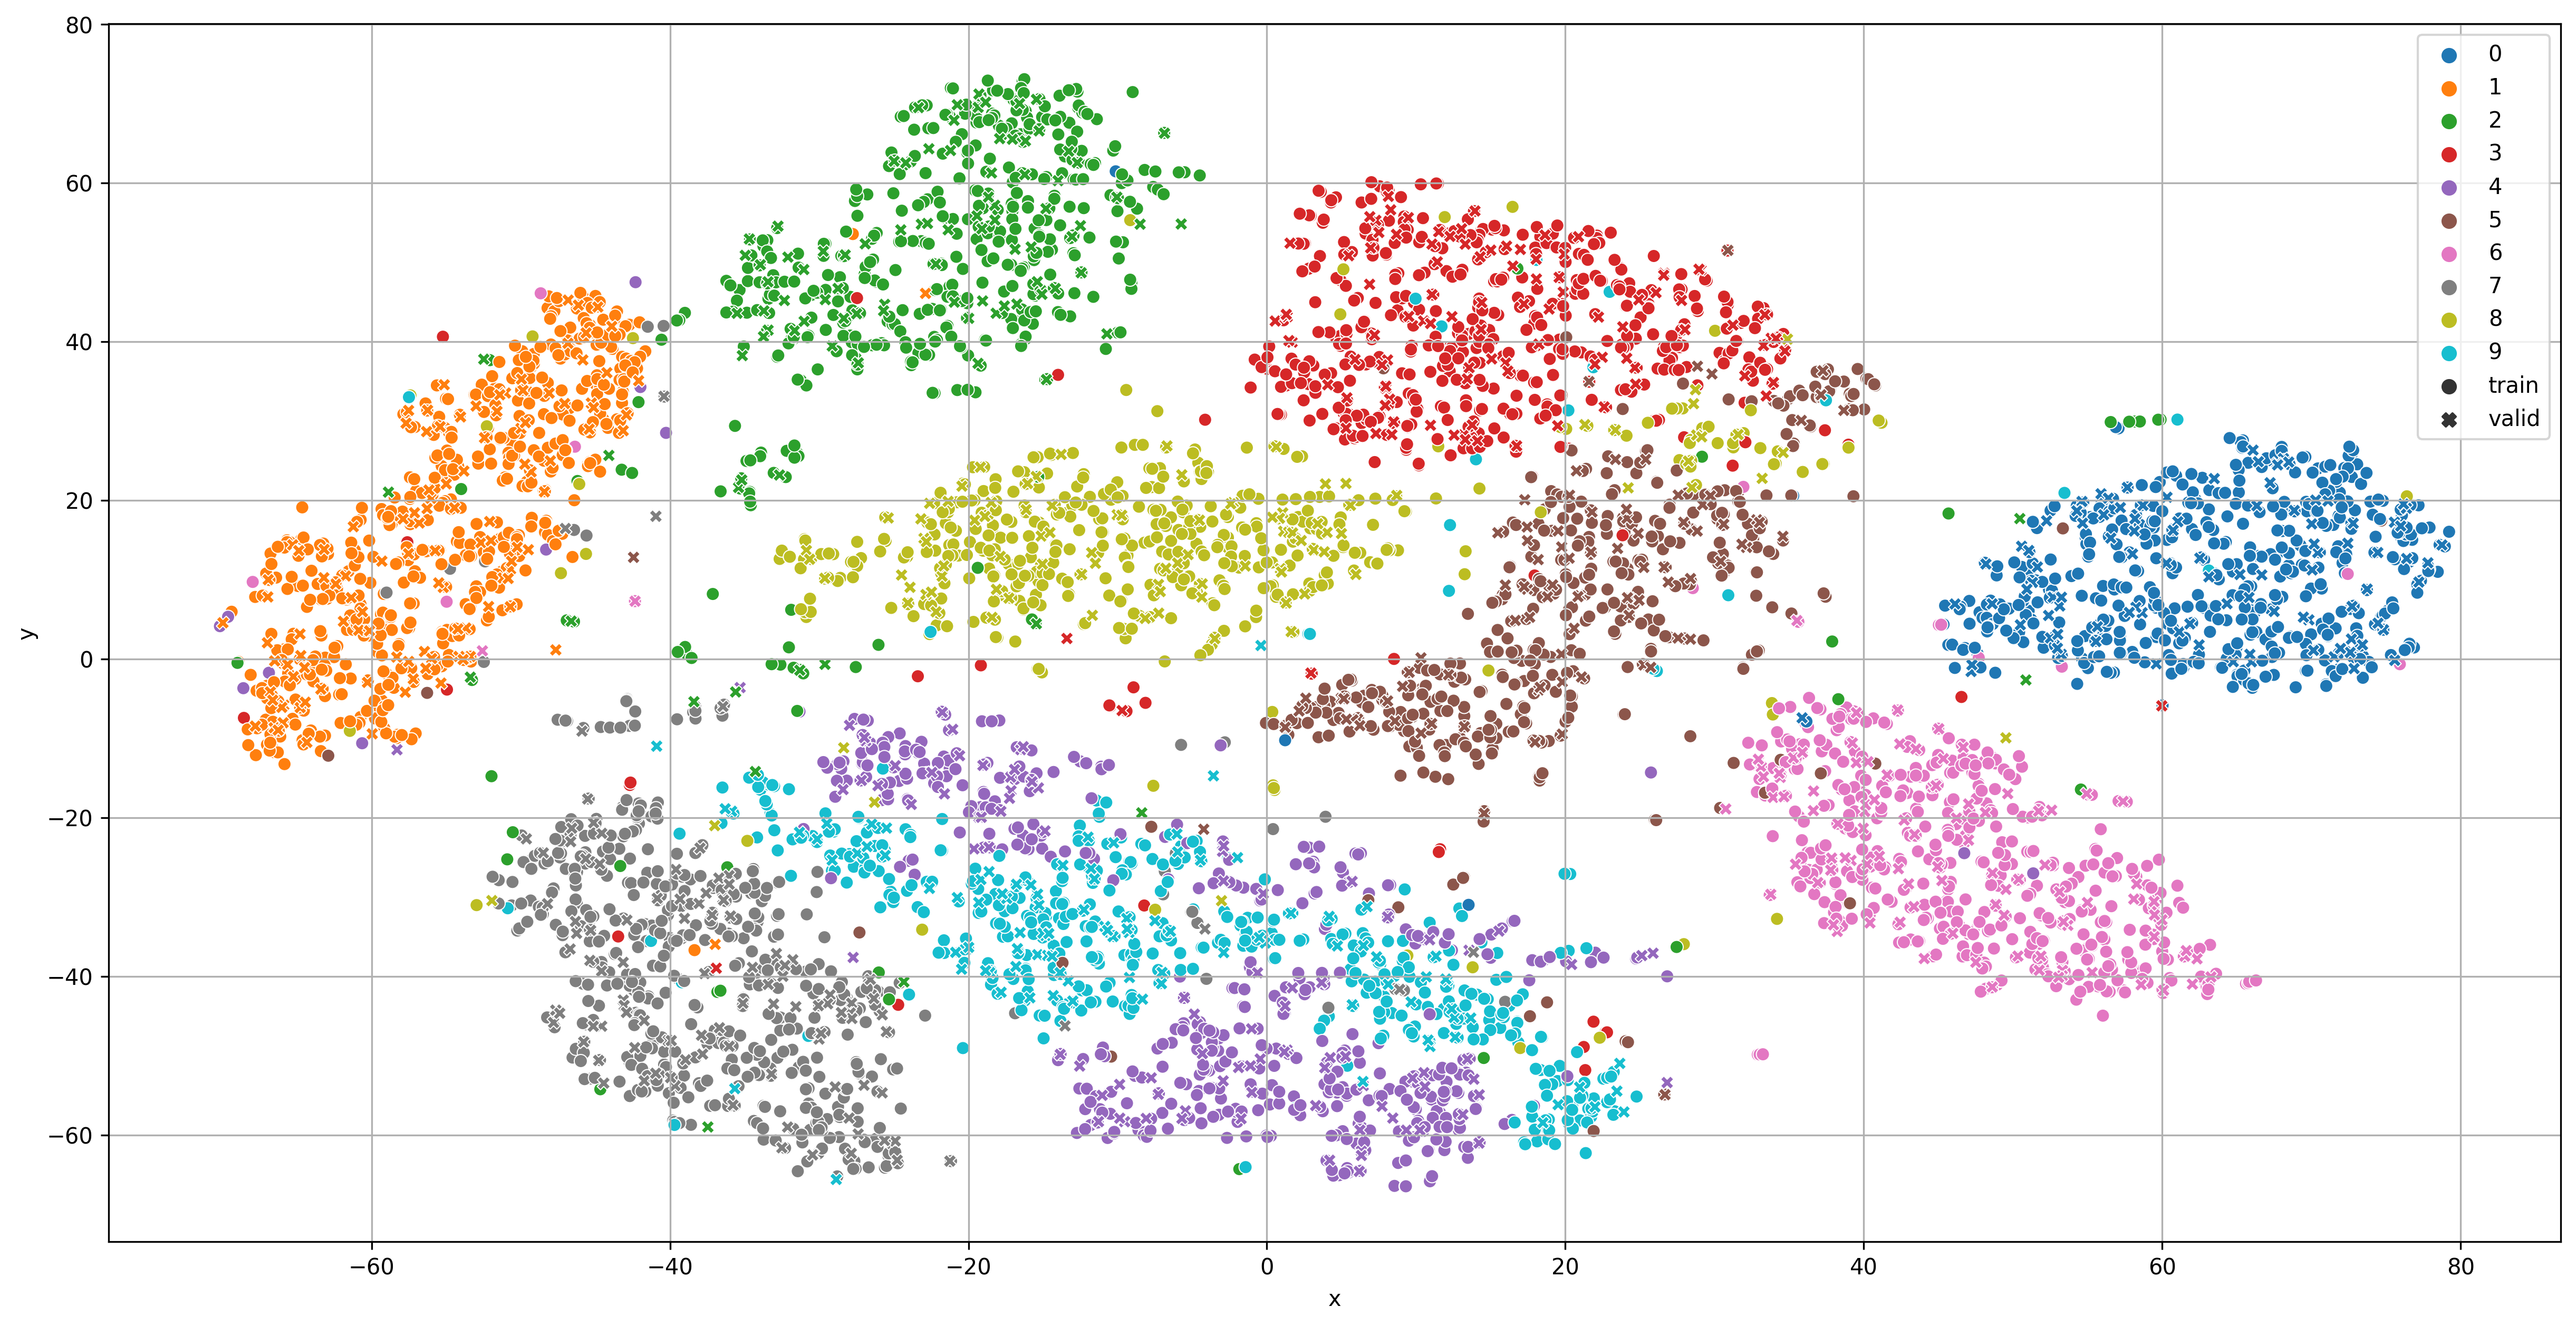

In [16]:
plt.figure(figsize=(20, 10), dpi=300)

sns.scatterplot(
    data=tsne_df,
    x='x',
    y='y',
    hue=pd.Categorical(np.hstack([y_train, y_test])),
    style=['train']*len(X_train) + ['valid']*len(X_test)
)

plt.grid(True)
plt.show()

## Low data-shapley value data visualization

In [17]:
df = pd.DataFrame(sv_matrix).groupby(y_pred).mean().T.apply(zscore, axis='index')

worst_idx = np.argsort(df.max(axis=1).to_numpy())

df.assign(label=y_train).iloc[worst_idx[:10]]

0         1         2         3         4         5         6  \
1714 -0.334387 -0.296262 -0.402237 -0.180338 -0.156807 -0.154644 -0.212378   
3286 -1.529817 -0.296262 -0.172987 -0.808094 -0.151738 -0.415939 -0.207914   
4124 -0.597212 -0.296263 -0.268210 -0.315232 -0.153635 -0.750345 -0.223368   
2570 -2.842520 -0.296361 -0.185548 -1.152325 -0.152425 -0.284214 -0.213881   
4625 -0.444681 -0.296540 -0.178542 -0.180158 -0.159478 -0.163057  0.072440   
4309 -0.415028 -0.296266 -0.699873 -0.187043 -0.186516 -0.156740 -0.230886   
4778 -0.223432 -0.296262 -0.172232 -0.214696 -0.159314 -0.157901 -0.209960   
248  -0.223671 -0.296272 -0.174472 -0.201058 -0.474434  0.088572 -0.210882   
4295 -0.263106 -0.296383 -0.190979 -2.111446 -0.157273 -0.278082 -0.208960   
76   -0.836109 -0.296266 -0.181190 -1.234592 -0.153630 -0.184084 -0.214397   

             7         8         9 label  
1714 -0.187164 -0.155681  0.035089     9  
3286 -0.191311 -0.362397  0.055152     9  
4124 -0.187360 -0.180970  0.059355     9  
2570 -0.204305 -0.219355  0.071294     9  
4625 -0.190917 -0.157748 -0.152471     6  
4309 -0.187737 -0.164023  0.081992     9  
4778  0.082672 -0.243314 -0.174757     7  
248  -0.190367 -0.160515 -0.153957     5  
4295 -0.193854 -0.231131  0.090434     9  
76   -0.188500 -0.192268  0.099463     9

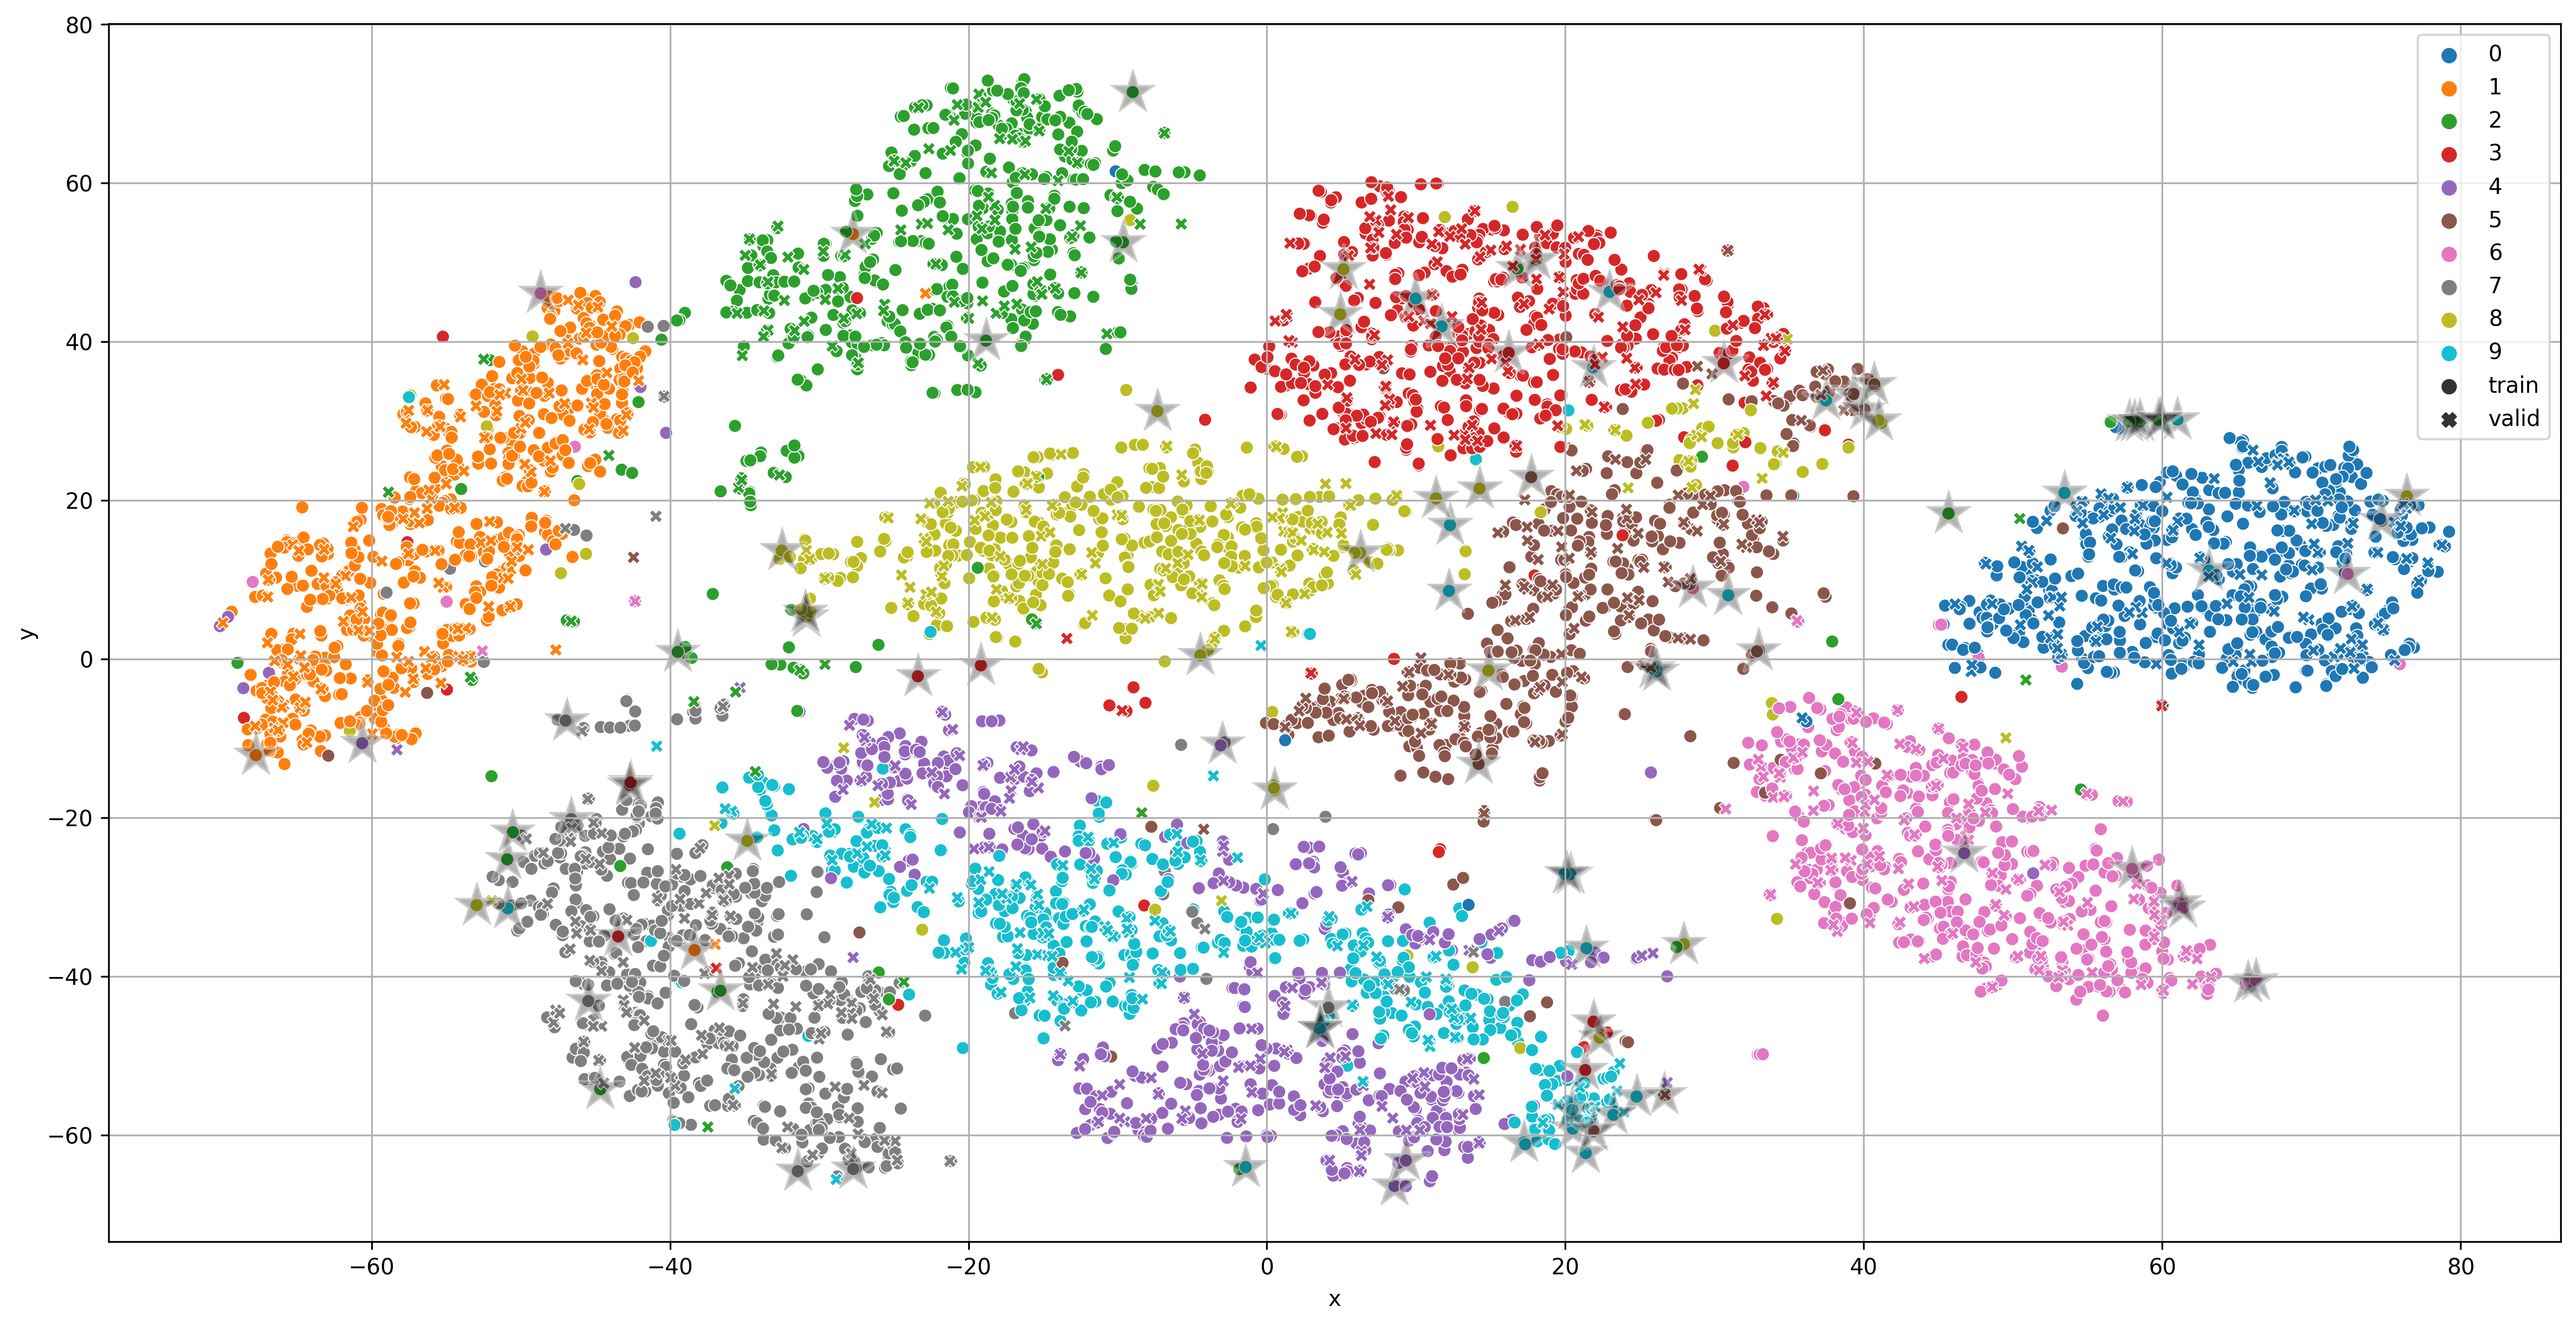

In [18]:
plt.figure(figsize=(20, 10), dpi=300)

sns.scatterplot(
    data=tsne_df,
    x='x',
    y='y',
    hue=pd.Categorical(np.hstack([y_train, y_test])),
    style=['train']*len(X_train) + ['valid']*len(X_test)
)

sns.scatterplot(
    data=tsne_df.iloc[worst_idx[:100]],
    x='x',
    y='y',
    s=500,
    alpha=0.3,
    color='k',
    marker='*'
)

plt.grid(True)
plt.show()

In [19]:
fig = px.scatter(
    data_frame=tsne_df.assign(
        label=np.hstack([y_train, y_test]),
        type=['train']*len(X_train) + ['valid']*len(X_test)
        ),
    x="x",
    y="y",
    color="label",
    symbol="type"
)

fig.add_trace(
    go.Scatter(
        x=tsne_df.loc[worst_idx[:70], 'x'],
        y=tsne_df.loc[worst_idx[:70], 'y'],
        mode='markers',
        marker=dict(
            size=16,
            symbol='x',
            color='rgba(255, 0, 0, 0)',
            line=dict(width=2, color='DarkSlateGrey')
        )
    )
)

fig.update_layout(
    width=1_600,
    height=1_000
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Experiment

In [20]:
def exp(clf, X_train, y_train, X_test, y_test, epoch:int=10):
    len_train = len(X_train)

    removed_data_percent = []

    chosen_sample_scores = []
    random_sample_scores = []

    chosen_X_train, chosen_y_train = X_train.copy(), y_train.copy()
    random_X_train, random_y_train = X_train.copy(), y_train.copy()

    n_sample = int(len_train / epoch)

    for i in tqdm(range(epoch), total=epoch):
        removed_data_percent.append(i * n_sample / len_train)

        if i == 0:
            clf.fit(X=X_train, y=y_train)

            chosen_sample_scores.append(clf.score(X_test, y_test))
            random_sample_scores.append(clf.score(X_test, y_test))

            y_pred = clf.predict(X_test)
            _, sv_matrix = compute_unweighted_knn_class_shapley(
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_pred,
                K=20
            )
            df = pd.DataFrame(sv_matrix).groupby(y_pred).mean().T.apply(zscore, axis='index')
            worst_idx = np.argsort(df.max(axis=1).to_numpy())
        else:
            # chosen sample
            chosen_n_sample_idx = worst_idx[n_sample:]  # remove train data with low data-shapley value
            # chosen_n_sample_idx = worst_idx[:-n_sample]  # remove train data with high data-shapley value

            chosen_X_train = chosen_X_train[chosen_n_sample_idx]
            chosen_y_train = chosen_y_train[chosen_n_sample_idx]

            clf.fit(X=chosen_X_train, y=chosen_y_train)
            chosen_sample_scores.append(clf.score(X_test, y_test))

            y_pred = clf.predict(X_test)
            _, sv_matrix = compute_unweighted_knn_class_shapley(
                X_train=chosen_X_train,
                y_train=chosen_y_train,
                X_test=X_test,
                y_test=y_pred,
                K=20
            )

            df = pd.DataFrame(sv_matrix).groupby(y_pred).mean().T.apply(zscore, axis='index')
            worst_idx = np.argsort(df.max(axis=1).to_numpy())

            # random sample
            np.random.seed(0)
            random_n_sample_idx = np.random.choice(a=list(range(len(random_X_train))), size=len(chosen_n_sample_idx))

            random_X_train = random_X_train[random_n_sample_idx]
            random_y_train = random_y_train[random_n_sample_idx]

            clf.fit(X=random_X_train, y=random_y_train)
            random_sample_scores.append(clf.score(X_test, y_test))

    return removed_data_percent, chosen_sample_scores, random_sample_scores

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


In [ ]:
removed_data_percent, chosen_sample_scores, random_sample_scores = exp(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epoch=10
    )

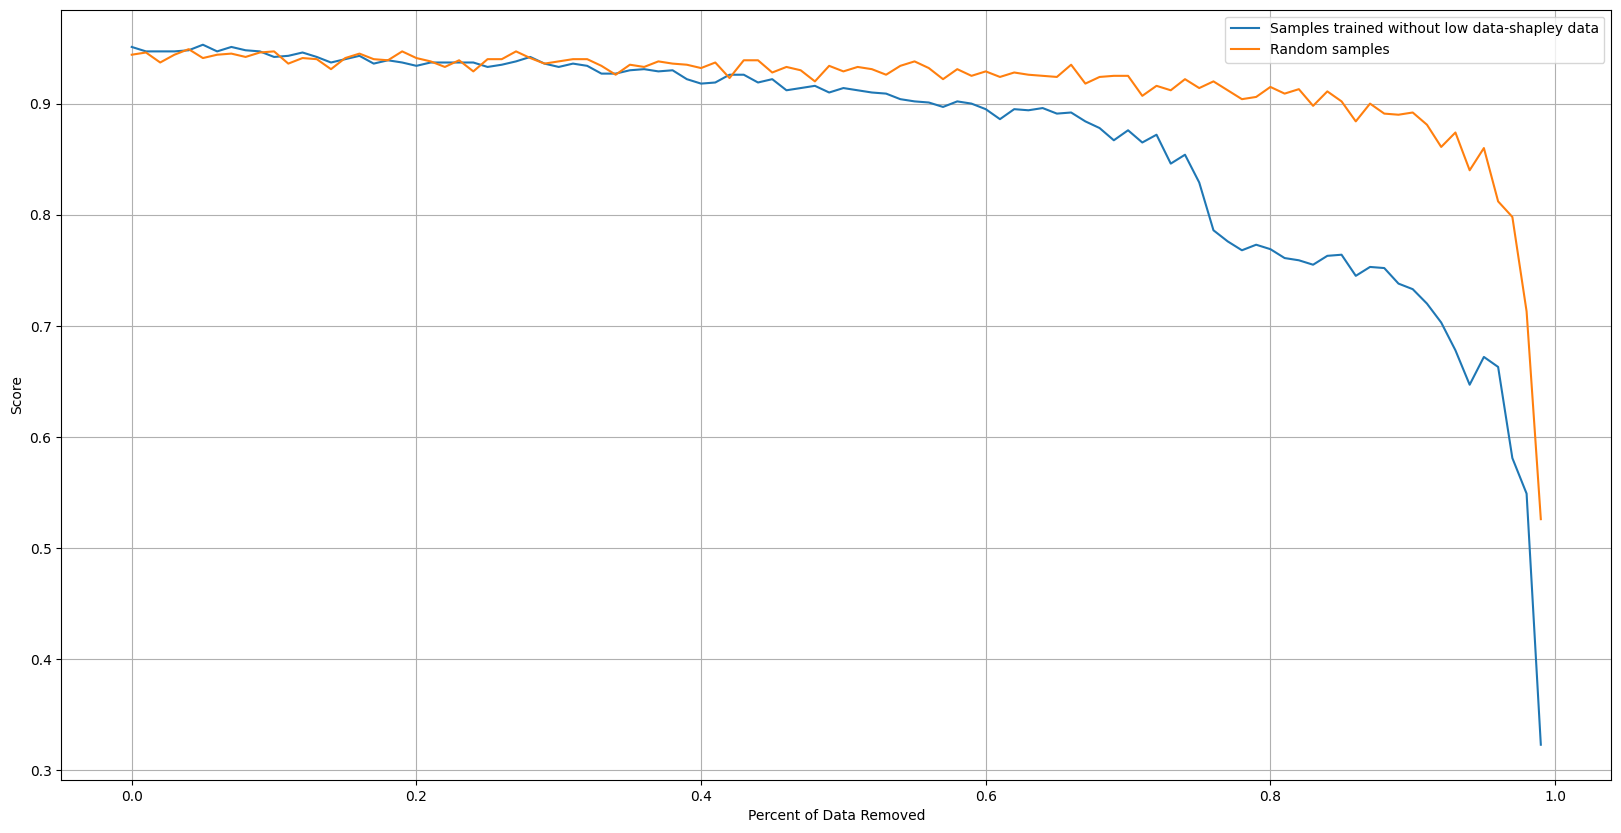

In [21]:
plt.figure(figsize=(20, 10))

sns.lineplot(
    x=removed_data_percent,
    y=chosen_sample_scores,
    label='Samples trained without low data-shapley data'
)

sns.lineplot(
    x=removed_data_percent,
    y=random_sample_scores,
    label='Random samples'
)

plt.legend()

plt.xlabel('Percent of Data Removed')
plt.ylabel('Score')

plt.grid(True)
plt.show()